**Author:** Neven Caplar and the LINCC team \
**Last updated:** Oct 25, 2024

## Overview

In this notebook we'll learn how to:
- Load object and source catalogs (lazily)
- Perform crossmatching with existing `LSDB` catalogs
- Save the results of a science workflow to disk

There is also an "Extra topics" section with details on crossmatching and margin caches.

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
from astropy.coordinates import SkyCoord

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hats.io.file_io import read_parquet_metadata

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')
# print(f'Version of hats is {hats.__version__}')

Version of lsdb is 0.4.1.dev10+g84465fa


We have numerous public catalogs available through [`data.lsdb.io`](https://data.lsdb.io).

In [28]:
catalogs_dir = "https://data.lsdb.io/hats"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf_dr14/ztf_object"
ztf_source_path = f"{catalogs_dir}/ztf_dr14/ztf_source"
ztf_object_margin_path = f"{catalogs_dir}/ztf_dr14/ztf_object_10arcs"

In [3]:
%%time

# Define a 1 degree cone region of interest
cone_search = ConeSearch(ra=-60, dec=20.5, radius_arcsec=1*3600)

# Load lite version of Gaia DR3 (RA and DEC data only)
gaia_lite = lsdb.read_hats(gaia_path, columns=["ra", "dec"], search_filter=cone_search)

# Load all Gaia data for the cone
gaia = lsdb.read_hats(gaia_path, search_filter=cone_search)

CPU times: user 816 ms, sys: 138 ms, total: 954 ms
Wall time: 1.29 s


## Reading Parquet Metadata

HiPSCat uses the Parquet file format to store catalogs. Parquet is a binary columnar data format, which means that information is efficiently encoded and compressed in binary format on disk, and is stored column wise in a way which allows efficiently loading only a subset of the columns. With each column, Parquet stores the column's metadata, including the column's name and data type.

Parquet also supports large datasets being partitioned into multiple files that are easier to work with individually. With a partitioned dataset, like HiPSCat uses, there are metadata files at the root folder containing the partitioned files that store the combined and common metadata of each of the individual partition files metadata. Here, we can read this `_common_metadata` which includes the schema of the dataset, consisting of the column metadata for all the columns in the dataset.

In [4]:
list(read_parquet_metadata(os.path.join(gaia_path+'/dataset', "_common_metadata")).schema)[:2]

[<ParquetColumnSchema>
   name: _healpix_29
   path: _healpix_29
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE,
 <ParquetColumnSchema>
   name: solution_id
   path: solution_id
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE]

## Lazy Operations

When working with large datasets, there is too much data to be loaded into memory at once. To get around this, LSDB uses the HiPSCat format which partitions a catalog into HEALPix cells and works on one partition at a time. This also allows the computation to be parallelized to work on multiple partitions at once. In order to efficiently carry out pipelines of operations though, it's better to batch operations so that multiple operations can be done back to back on the same partition instead of having to load and save each partition from storage after every operation.

For this reason, operations in LSDB are performed 'lazily'. This means when a catalog is read using `read_hipscat`, the actual catalog data isn't being read from storage. Instead, it only loads the metadata such as the column schema and the HEALPix structure of the partitions. When an operation like `cone_search` is called on a catalog, the data is not actually loaded and operated on when the line of code is executed. Instead, the catalog keeps track of the operations that it needs to perform so the entire pipeline can be efficiently run later. This also allows us to optimize the pipeline by only loading the partitions that are necessary. For example when performing a cone search like we do here, we only need the partitions that have data within the cone.

![lazy loading diagram](https://raw.githubusercontent.com/astronomy-commons/lsdb/main/docs/_static/lazy_diagram.svg)

So when we look at a catalog that has been lazy loaded we see the DataFrame without the data, just the columns and the number of partitions (including the HiPSCat index of each partition encoding which HEALPix cell the partition is in). 

In [5]:
gaia_lite

Dask NestedFrame Structure:
                                 ra              dec
npartitions=4                                       
911415974589104128  double[pyarrow]  double[pyarrow]
911697449565814784              ...              ...
913175193193545728              ...              ...
913386299426078720              ...              ...
913667774402789376              ...              ...
Dask Name: search_points, 5 expressions
Expr=MapPartitions(search_points)

To load the data and perform the operations, call `compute()` which will load the necessary data and perform all the operations that have been called, and return a Pandas DataFrame with the results.

In [6]:
gaia_lite_computed = gaia_lite.compute()

In [7]:
gaia_lite_computed

ra        dec
_healpix_29                              
911516029997837890     300.323   19.54927
911516751291858136  300.354463  19.558069
911516751331565329  300.353417  19.558007
911516759057245949  300.336424  19.551617
911516759201236548  300.336033  19.552258
...                        ...        ...
913459016261321131  300.117206  21.493197
913459016461577864  300.119462  21.492589
913459016601843087  300.118743  21.493434
913459017549638235  300.124771   21.49295
913459039300243112  300.114821  21.494043

[804414 rows x 2 columns]

## HATS (Hierarchal Adaptive Tiling Scheme) Partitioning

To make it easier and more efficient to perform operations in parallel, HATS partitions contain roughly the same number of rows. This is done by using different HEALPix pixel sizes for different parts of the sky depending on the density of sources. This means catalogs with more rows will have smaller pixels for each partition, and so will have more partitions overall. We can see this below with the ZTF object and source catalogs, where the source catalog with many more data points has more partitions to keep the size of each partition consistent.

In [8]:
%%time
ztf_object = lsdb.read_hats(ztf_object_path, columns=["ra", "dec"]) # ZTF Object
ztf_source = lsdb.read_hats(ztf_source_path, columns=["ra", "dec"]) # ZTF Source

CPU times: user 5.42 s, sys: 182 ms, total: 5.6 s
Wall time: 5.9 s


In [9]:
ztf_object

Dask NestedFrame Structure:
                                  ra              dec
npartitions=2352                                     
0                    double[pyarrow]  double[pyarrow]
4503599627370496                 ...              ...
...                              ...              ...
3457638613913698304              ...              ...
3458764513820540928              ...              ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

In [10]:
ztf_source

Dask NestedFrame Structure:
                                  ra              dec
npartitions=41679                                    
0                    double[pyarrow]  double[pyarrow]
1125899906842624                 ...              ...
...                              ...              ...
3458483038843830272              ...              ...
3458764513820540928              ...              ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

In [11]:
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

# Define the center of the field of view
# For example: Right Ascension (RA) = 10 degrees, Declination (Dec) = 40 degrees
center = SkyCoord(ra=10*u.deg, dec=40*u.deg, frame='icrs')

# Define the field of view extent
# For example, using a radius of 1 degree
fov_radius = Angle(1, unit=u.deg)



We can see this difference in partition pixel sizes by plotting the HEALPix pixels of the partitions in the catalogs.

(<Figure size 2000x800 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - ztf_dr14'}>)

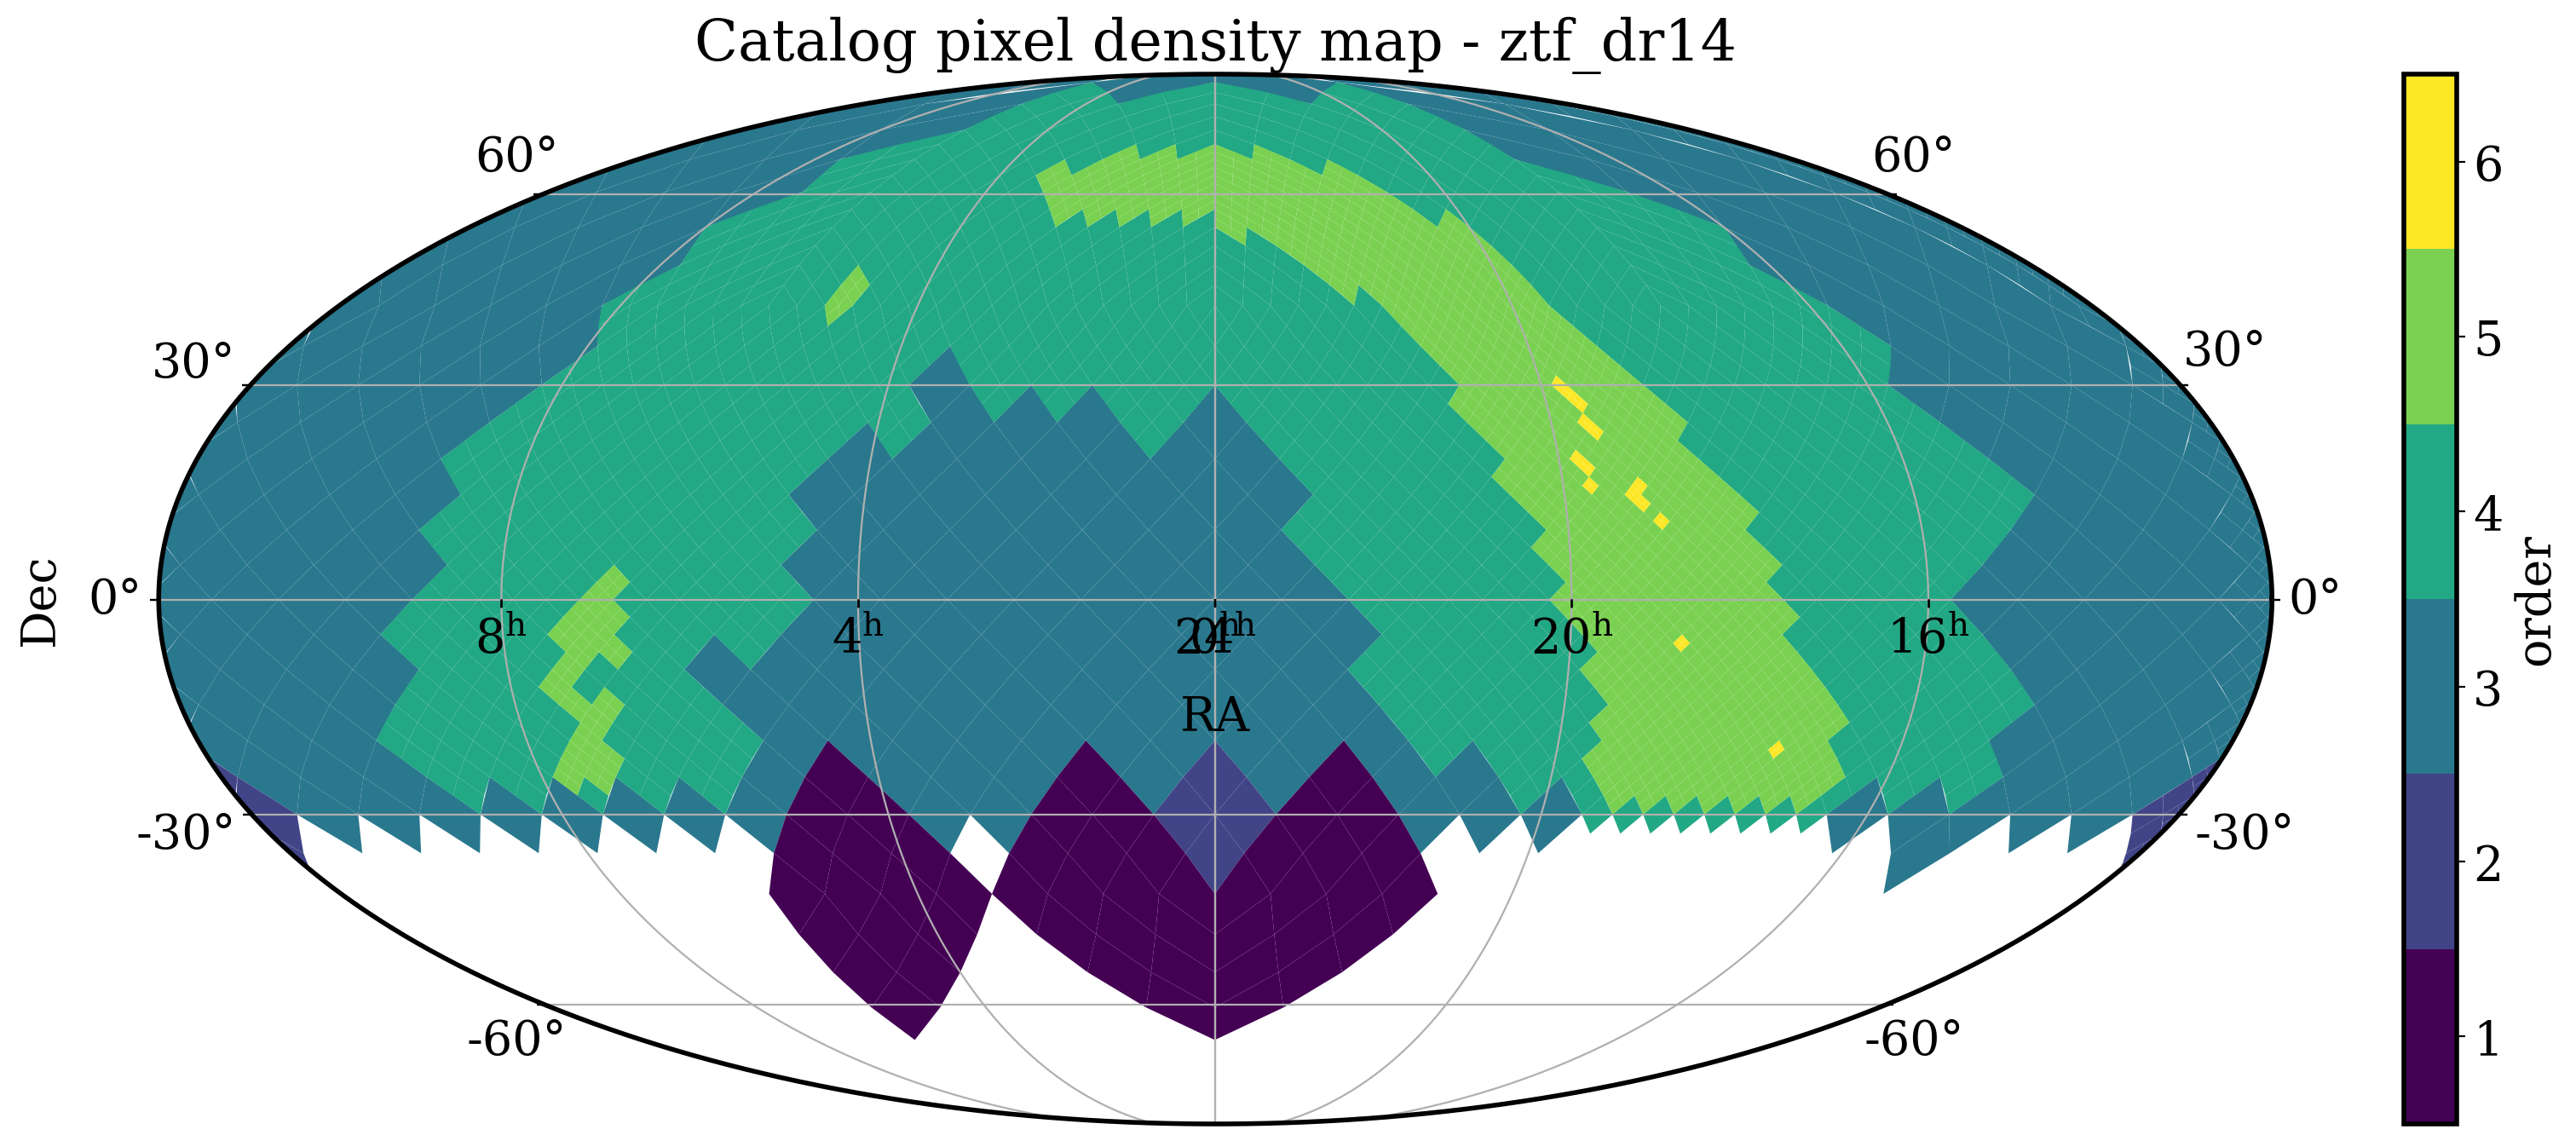

In [12]:
# Plot the Pixel Density Maps for Gaia and ZTF
# gaia.plot_pixels()
#fig1 = plt.figure(figsize=(20, 10))
#ztf_object.plot_pixels(fig=fig1)

fig2 = plt.figure(figsize=(20, 8))
ztf_object.plot_pixels(fig=fig2)
# TODO: show which part we will zoom into

(<Figure size 2000x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog point density map - ztf_dr14'}>)

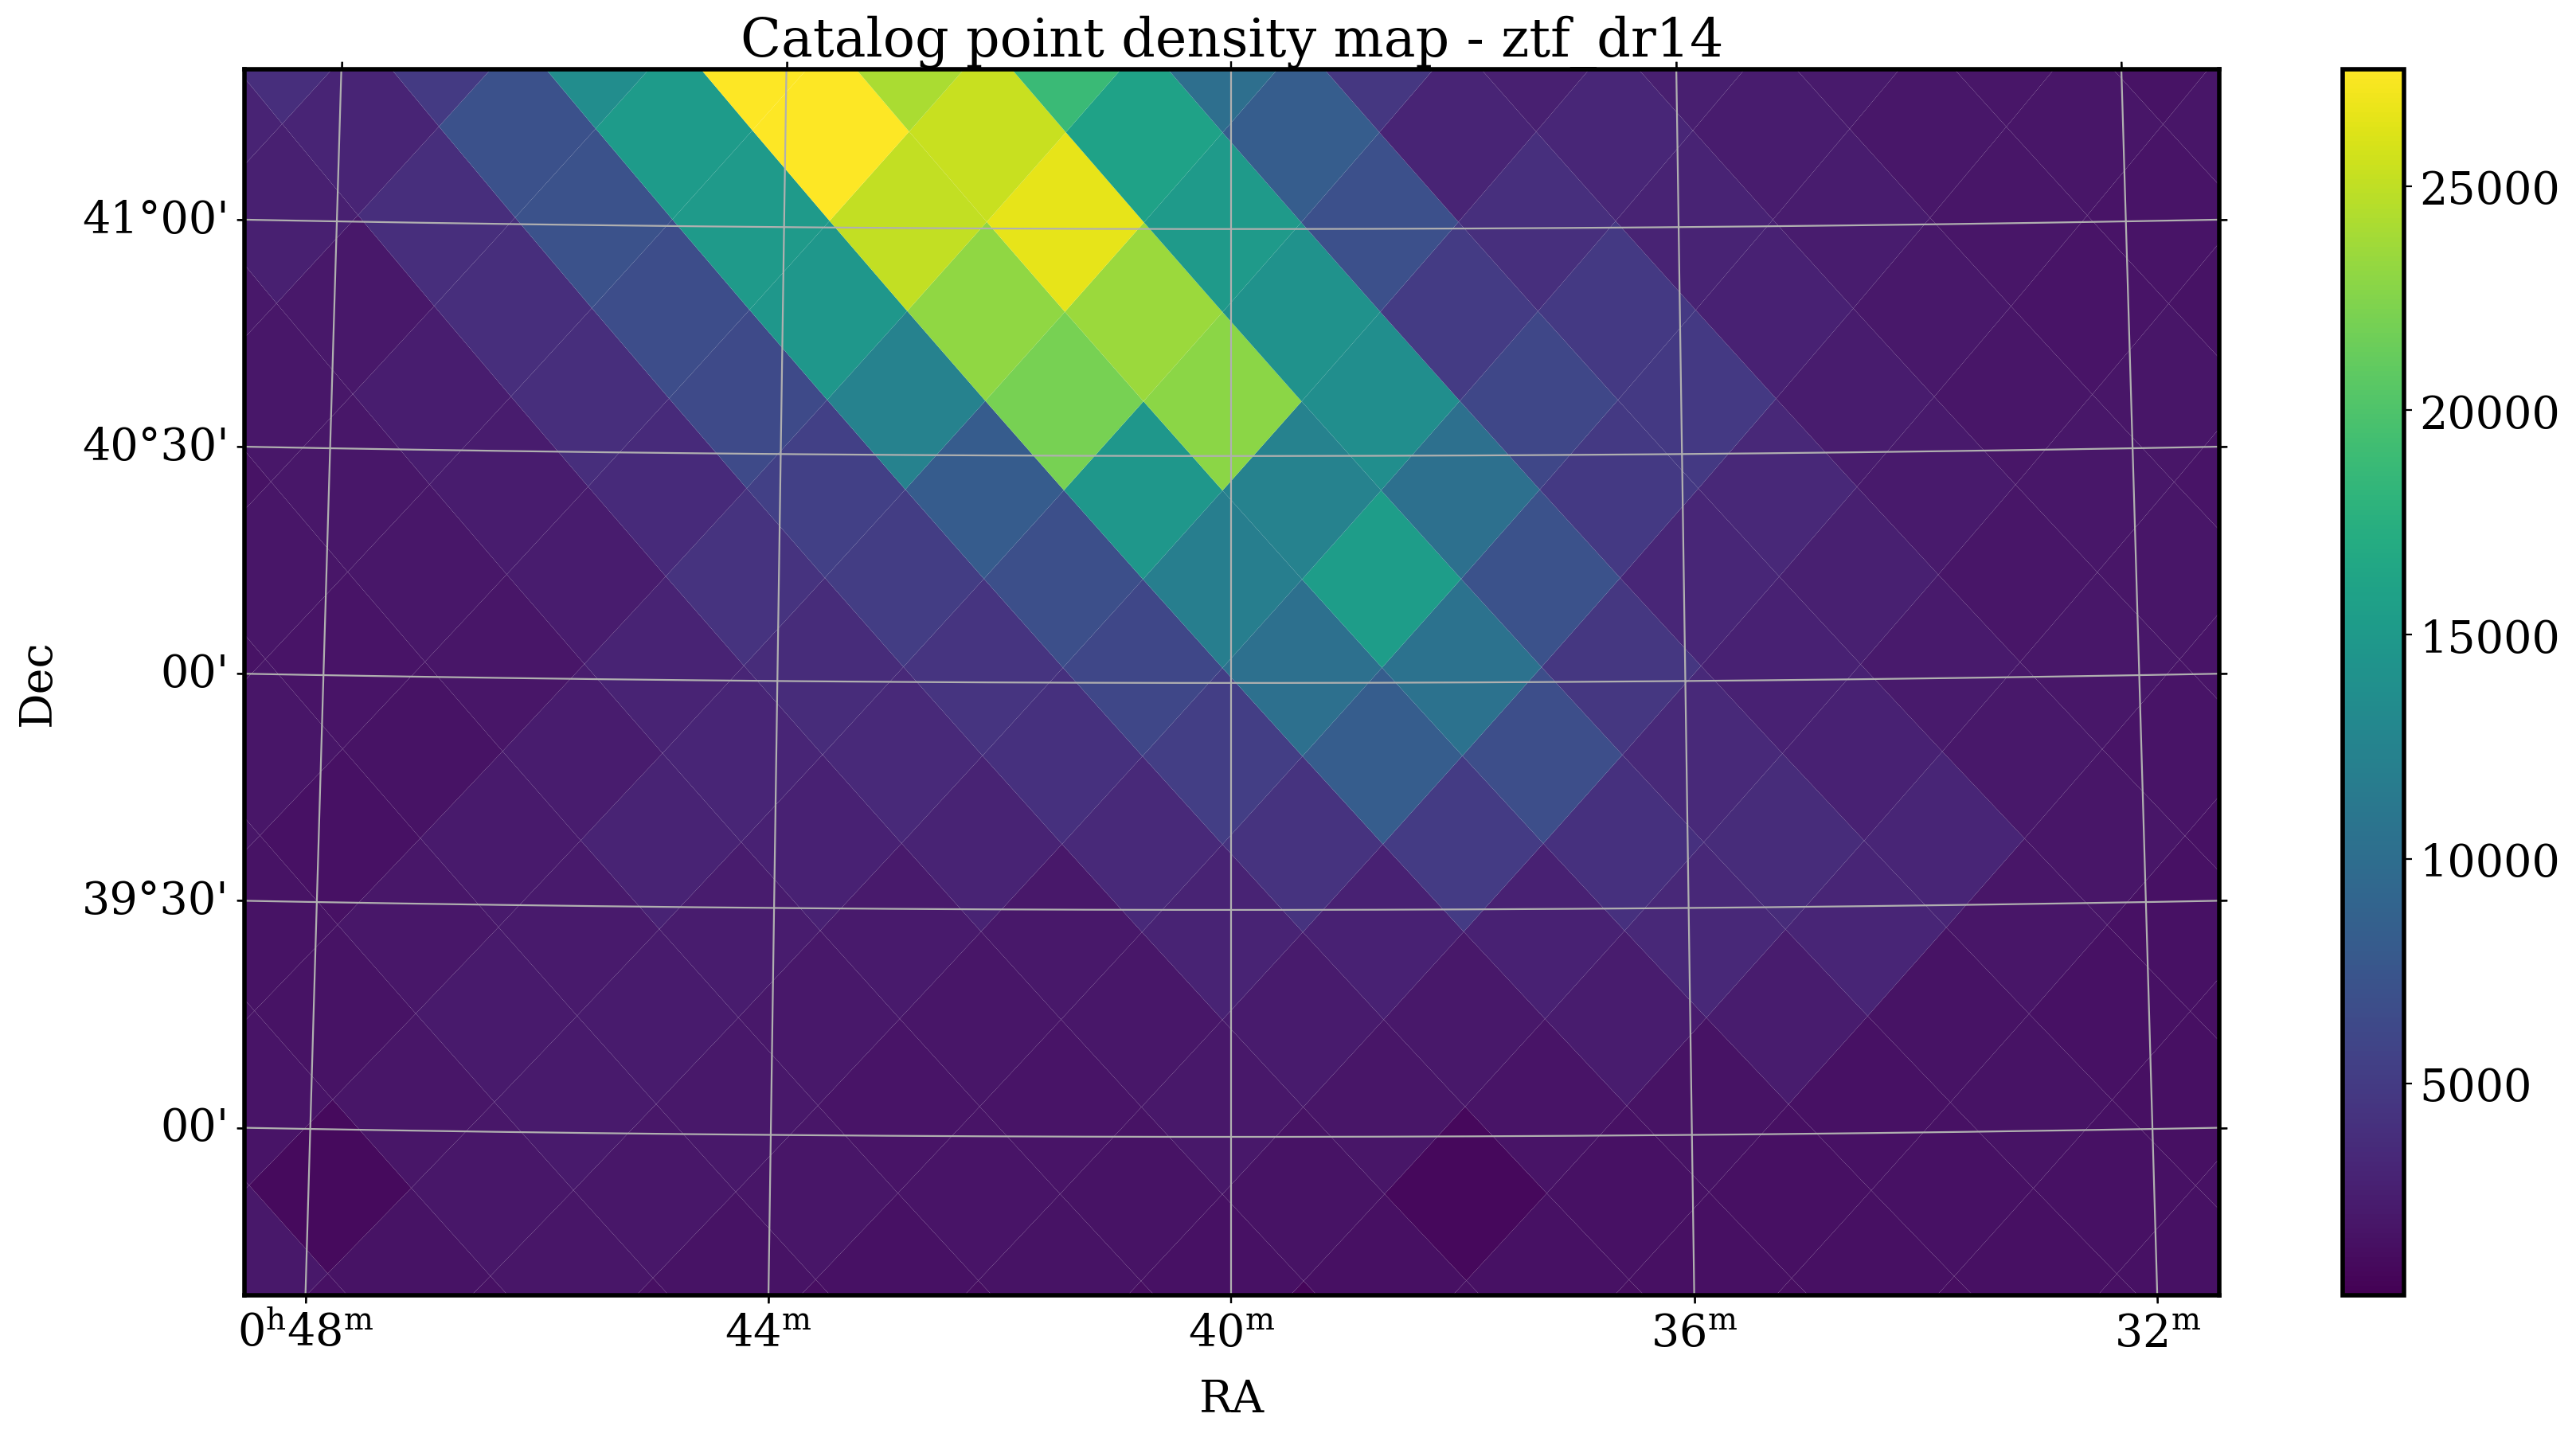

In [23]:
fig3 = plt.figure(figsize=(20, 10))
plot_points(ztf_object.hc_structure, fig=fig3, center= center, fov =(Angle(3, 'deg'), Angle(3, 'deg')))
# TODO: Overplot the points on the pixel density map

## Crossmatching

Let's crossmatch our Gaia region with ZTF.

In [15]:
gaia_lite

Dask NestedFrame Structure:
                                 ra              dec
npartitions=4                                       
911415974589104128  double[pyarrow]  double[pyarrow]
911697449565814784              ...              ...
913175193193545728              ...              ...
913386299426078720              ...              ...
913667774402789376              ...              ...
Dask Name: search_points, 5 expressions
Expr=MapPartitions(search_points)

In [16]:
ztf_object

Dask NestedFrame Structure:
                                  ra              dec
npartitions=2352                                     
0                    double[pyarrow]  double[pyarrow]
4503599627370496                 ...              ...
...                              ...              ...
3457638613913698304              ...              ...
3458764513820540928              ...              ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

In [17]:
%time
xmatch_object = gaia_lite.crossmatch(ztf_object)

CPU times: user 11 μs, sys: 1 μs, total: 12 μs
Wall time: 27.2 μs


/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


## The `head` method

For large operations we might want to see a small subset of the computed final data without doing the full computation. Like pandas, we can use the `head` operation to compute the first n rows of the final dataframe without computing the whole dataset.

In [18]:
xmatch_object.head(5)

ra_gaia   dec_gaia  ra_ztf_dr14  dec_ztf_dr14  \
_healpix_29                                                            
911516029997837890     300.323   19.54927   300.322998     19.549284   
911516751291858136  300.354463  19.558069   300.354462     19.558081   
911516751331565329  300.353417  19.558007   300.353401     19.558013   
911516759057245949  300.336424  19.551617   300.336411     19.551633   
911516759928741915  300.336573  19.552868   300.336571     19.552879   

                    _dist_arcsec  
_healpix_29                       
911516029997837890      0.050271  
911516751291858136      0.043431  
911516751331565329      0.058879  
911516759057245949      0.072412  
911516759928741915      0.039042

Here we load the ZTF object catalog again, this time with all the columns that we'll need to perform the analysis later. 

Note the previous warning about margin caches. Margins allow you to crossmatch objects which might be just across the border, in the neighboring pixels, which you might miss if you only search among the objects in a given pixel. We'll also be specifying the margin for ZTF.

In [29]:
%%time
# load ZTF with all columns and specify the margin cache!
ztf_object_full = lsdb.read_hats(ztf_object_path, margin_cache=ztf_object_margin_path)

CPU times: user 876 ms, sys: 27.8 ms, total: 904 ms
Wall time: 943 ms


In [30]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf_object_full).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

CPU times: user 1.2 s, sys: 29.9 ms, total: 1.23 s
Wall time: 1.23 s


In [31]:
%%time
total = _all_sky_object.compute()

CPU times: user 26.1 s, sys: 35 s, total: 1min 1s
Wall time: 12.3 s


In [32]:
# this is the dataframe with all the computed objects
total

solution_id_gaia              designation_gaia  \
_healpix_29                                                             
911516769815672425  1636148068921376768  Gaia DR3 1823033542087957248   
911516962420281537  1636148068921376768  Gaia DR3 1823033920045097728   
911517082242484446  1636148068921376768  Gaia DR3 1823034156246247424   
911519842177649100  1636148068921376768  Gaia DR3 1823039658126194176   
911519844300632277  1636148068921376768  Gaia DR3 1823039692480622976   
...                                 ...                           ...   
913457273659285655  1636148068921376768  Gaia DR3 1826914543258245888   
913457307216320954  1636148068921376768  Gaia DR3 1826914611977691264   
913457311858327795  1636148068921376768  Gaia DR3 1826914611977688704   
913457391885390984  1636148068921376768  Gaia DR3 1826914783776458624   
913458916685941620  1636148068921376768  Gaia DR3 1826917807433482752   

                         source_id_gaia  random_index_gaia  ref_epoch_gaia  \
_healpix_29                                                                  
911516769815672425  1823033542087957248          681413300          2016.0   
911516962420281537  1823033920045097728          606871238          2016.0   
911517082242484446  1823034156246247424          987360779          2016.0   
911519842177649100  1823039658126194176         1633982299          2016.0   
911519844300632277  1823039692480622976          367753372          2016.0   
...                                 ...                ...             ...   
913457273659285655  1826914543258245888         1528507267          2016.0   
913457307216320954  1826914611977691264         1690142768          2016.0   
913457311858327795  1826914611977688704          996564350          2016.0   
913457391885390984  1826914783776458624         1445282743          2016.0   
913458916685941620  1826917807433482752          832277656          2016.0   

                       ra_gaia  ra_error_gaia   dec_gaia  dec_error_gaia  \
_healpix_29                                                                
911516769815672425  300.344658       0.028663  19.554414        0.027776   
911516962420281537  300.426663       0.014488  19.587297        0.014479   
911517082242484446  300.422159       0.042693  19.608572        0.041722   
911519842177649100  300.549673       0.041812  19.653736        0.039993   
911519844300632277    300.5315       0.037491  19.641191        0.035262   
...                        ...            ...        ...             ...   
913457273659285655  300.190156        0.03939  21.451042        0.039384   
913457307216320954  300.222469       0.036843  21.458198        0.039499   
913457311858327795  300.229901       0.015495  21.465304        0.016096   
913457391885390984  300.154678       0.031628  21.454938        0.034043   
913458916685941620  300.133704       0.035317  21.486115        0.038298   

                    parallax_gaia  ...  nobs_g_ztf_dr14  nobs_r_ztf_dr14  \
_healpix_29                        ...                                     
911516769815672425       0.668537  ...              404             1009   
911516962420281537        0.97283  ...              101              373   
911517082242484446       0.350765  ...               94              362   
911519842177649100       0.485155  ...              352              953   
911519844300632277       0.380807  ...              396             1008   
...                           ...  ...              ...              ...   
913457273659285655       0.311161  ...              398             1000   
913457307216320954       0.474479  ...              376              953   
913457311858327795       1.378988  ...              404             1004   
913457391885390984       0.472456  ...              352              968   
913458916685941620       0.499131  ...              352              948   

                    nobs_i_ztf_dr14  mean_mag_g_ztf_dr14  mean_mag_r_ztf_dr14  \

Let us now visualize the GAIA object that got matched and the all of the starting GAIA matches. The red circle shows the cone in which we conducted the cross-match. Note the patch where there are no cross-matches because of a gap in the ZTF coverage.

/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/astro/users/ncaplar/.conda/envs/lsdb_adass/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


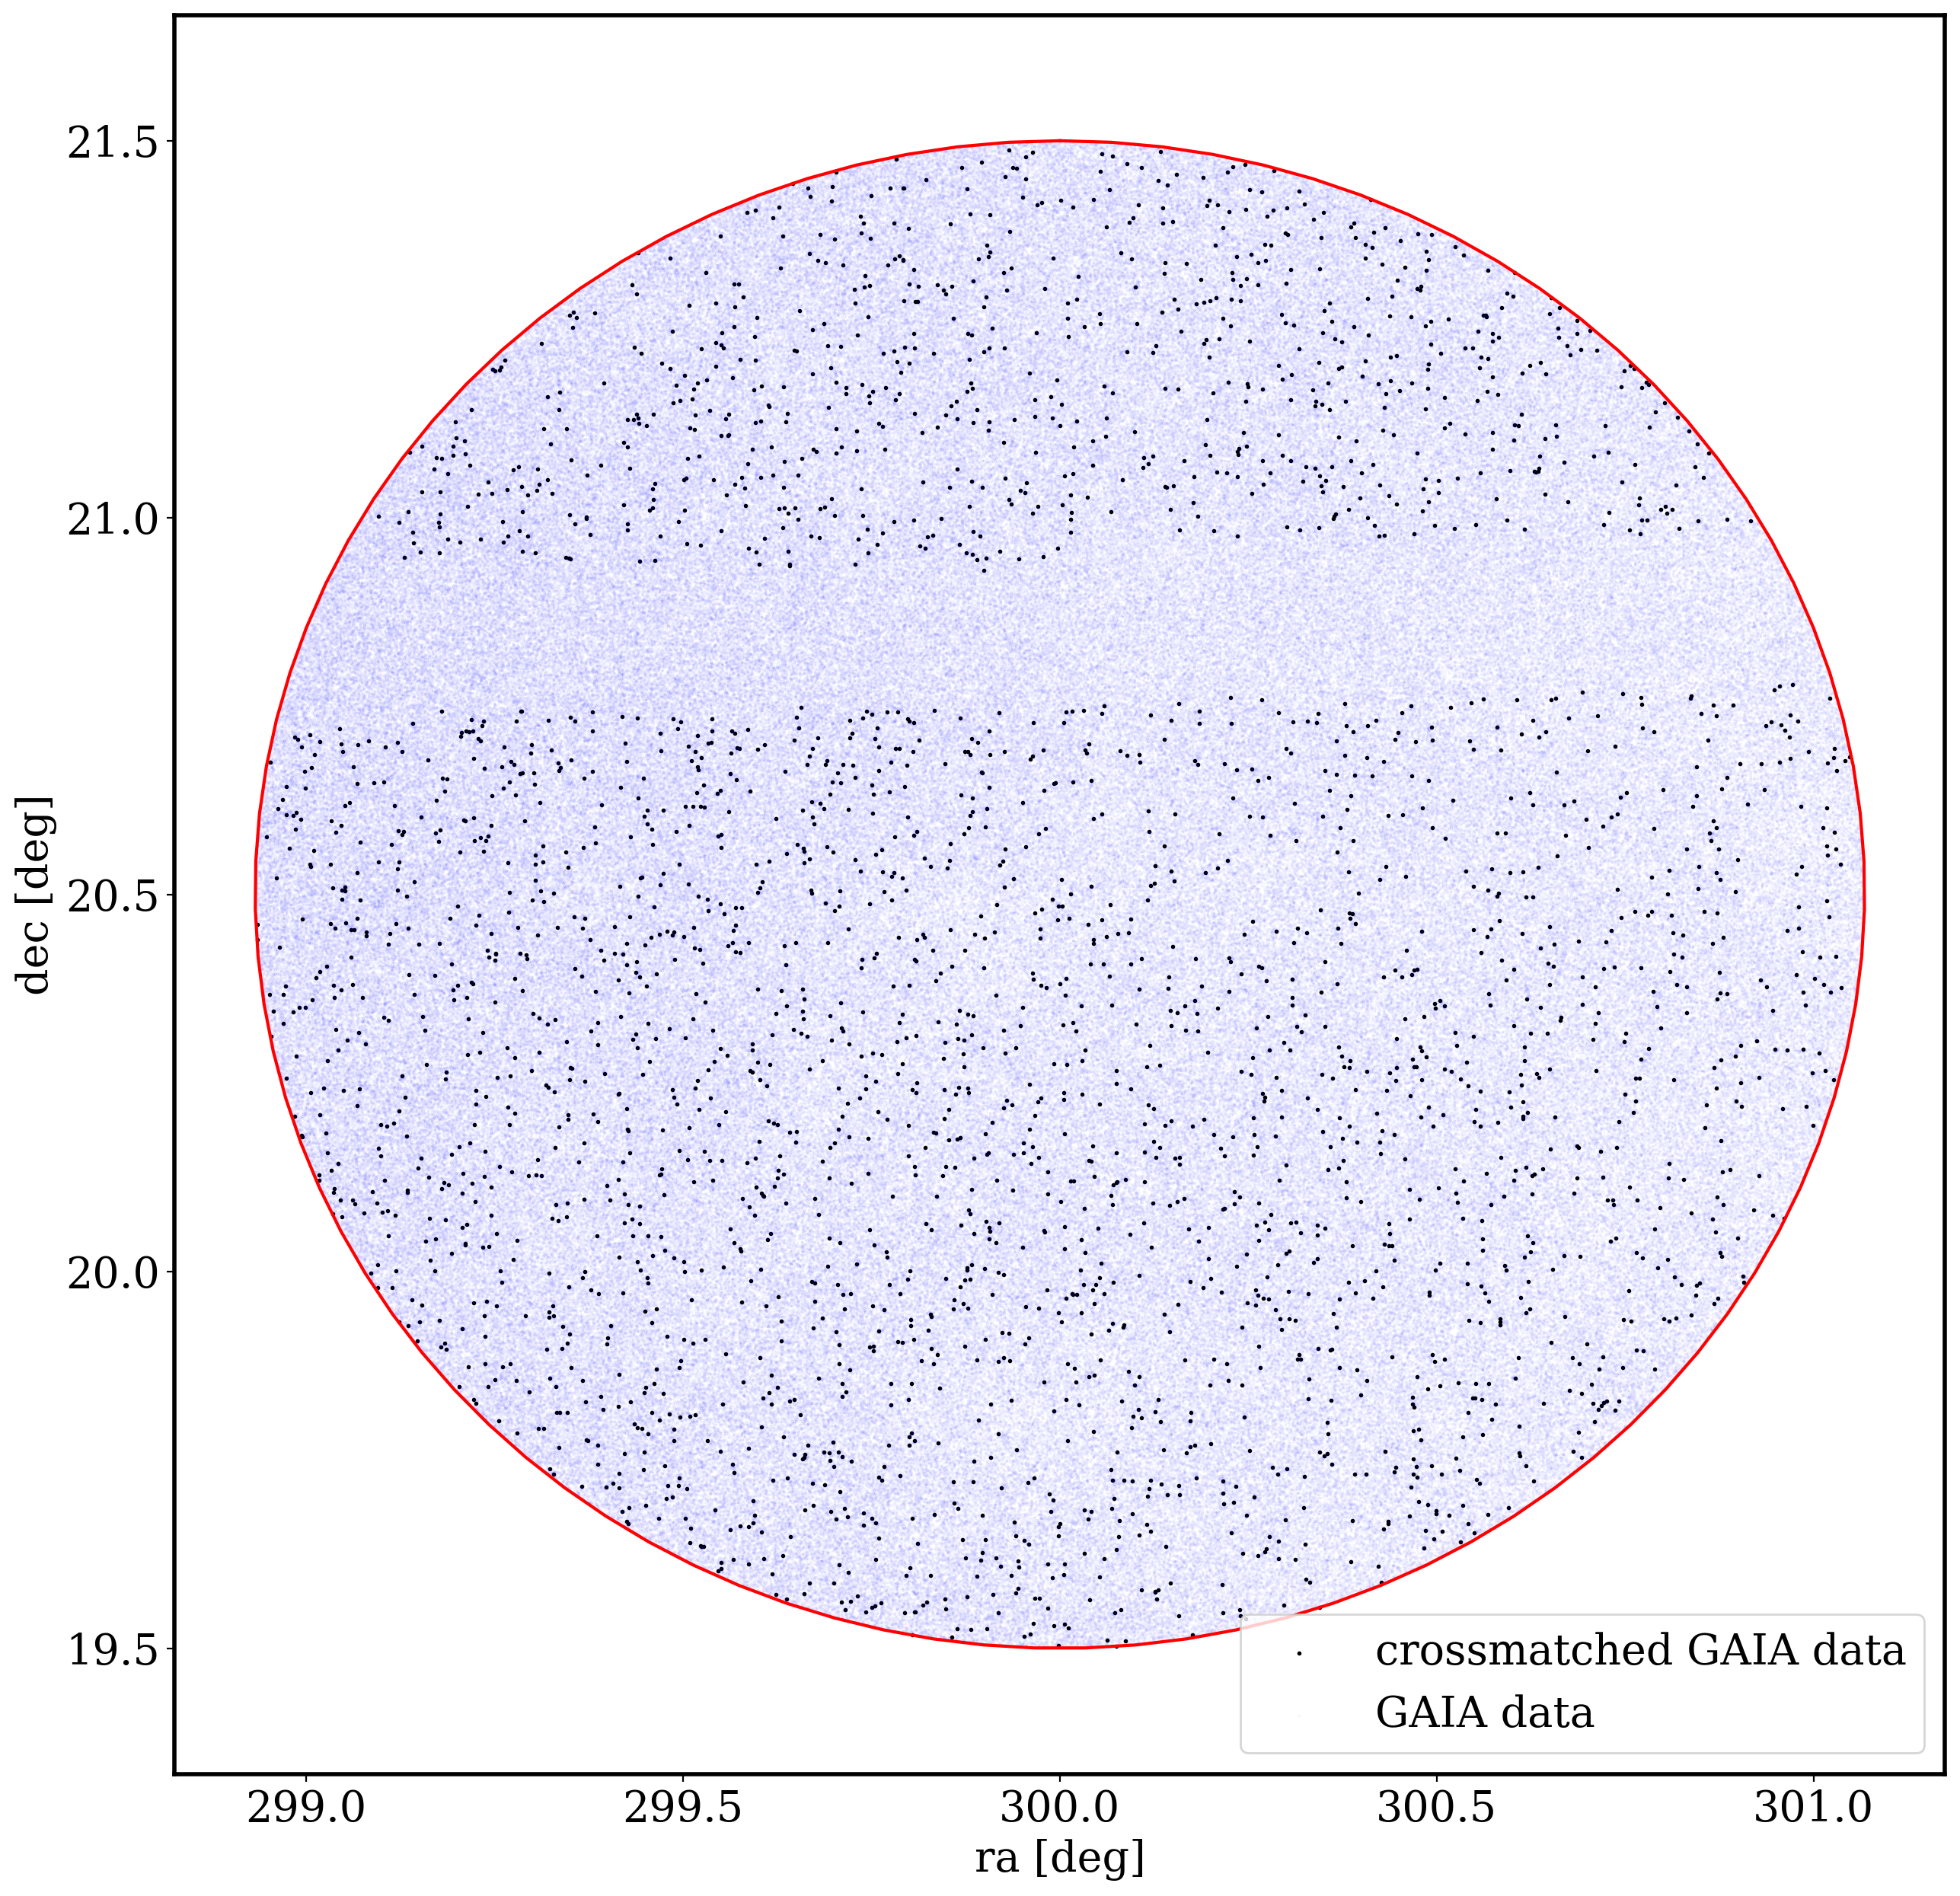

In [33]:
plt.figure(figsize=(15,15))
plt.scatter(total['ra_gaia'].values, total['dec_gaia'].values, color='black', s=1, label='crossmatched GAIA data')
plt.scatter(gaia_lite_computed['ra'], gaia_lite_computed['dec'], color='blue', s=0.1, alpha=0.05, label='GAIA data')

circle_center = SkyCoord(ra=300 * u.deg, dec=20.5 * u.deg)
circle_coord = circle_center.directional_offset_by(
    position_angle=np.linspace(0, 360, 100) * u.deg,
    separation=1 * u.deg
)
plt.plot(circle_coord.ra.deg, circle_coord.dec.deg, color='red')

plt.axis('equal')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.legend()

## Export catalogs to disk

Once the analysis is complete we can export our results in the hipscat format. To do so you would uncomment the line below. You need to provide a base directory path for your catalog and you should also provide a catalog name that expresses the nature of your data. You can load the saved catalog back via LSDB, or you can load the parquet files that are saved to disk with any other parquet reader of your choice.

In [19]:
# export crossmatched data to disk
# _all_sky_object.to_hipscat(base_catalog_path="ztf_x_gaia", catalog_name="ztf_x_gaia")

## Extra topics

### Crossmatching

Catalogs have valuable metadata about their partitioning structure (e.g. the sky coverage and the order of the pixels at each point in the sky). LSDB takes advantage of this information for operations like joining/crossmatching to identify pairs of partitions that are spatially close to each other in the sky. Each core available to your distributed Dask client will process a pair of partitions at a time.

![Crossmatch diagram](https://raw.githubusercontent.com/lincc-frameworks/MWGaia-DN_Introductory_School/main/assets/crossmatch-diagram.jpg)

The built-in crossmatching algorithm is the **K-Nearest Neighbors**. By default, we look for single matches within 1 arcsecond of each object.

```python
gaia_lite.crossmatch(ztf_object, n_neighbors=1, radius_arcsec=1)
```

### Margin caches

Remember the **warning** about the missing margin cache?

```
RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
```

Margins are catalogs that specify what objects, for each pixel, are within a certain distance of their borders. They allows us to crossmatch objects which might be just across the border, in the neighboring pixels, which you might miss if you only search among the objects in a given pixel. 

In the image below we are trying to obtain the matches for the points in the "green" pixel. The closest match for the selected green object is in a different pixel. The closest green neighbor to this object is not even within the specified crossmatching radius (seen in dark green). This means that, without margin caches, this green object would simply not have a match, which is inaccurate!

![Margin cache diagram](https://lsdb.readthedocs.io/en/stable/_images/pixel-boundary-example.png)

Notice that your crossmatching distance, `radius_arcsec`, should not be larger than your margin cache radius. You can usually infer the margin cache radius from the catalog name, or look for it programatically.

In [20]:
ztf_object_full.margin.hc_structure.catalog_info.margin_threshold

10